# Driverless AI MLI BYOR: Custom Explainers

Driverless AI provides robust interpretability of machine learning models
to explain modeling results in a human-readable format. In the 
Machine Learning Interpetability (MLI) view, Driverless AI offers various
techniques and methodologies for interpreting and explaining the results
of its models. These techniques are implemented as extensible set of recipes.

This notebook demonstrates how to list, search, run and get results of
**custom** Driverless AI explainer **recipe**.

## Install

Run this notebook in Python environment where you downloaded and installed **generated** Driverless AI **client**. Generated client can be downloaded from Driverless AI server on the following URL:

* `https://<host>:<port>/<context>/clients/py/old`

For example:
    
* https://driverlessai.intranet.com:12345/clients/py/old
* https://enterprise-puddle.h2o.ai/02d26869-7083-4351-95fa-6af57e0547b4/clients/py/old
    
And install the wheel (`x.xx.x` to be replaced with your Driverless AI version):

```
pip install ./h2oai_client-x.xx.x-py3-none-any.whl
```

Import required packages and modules:

In [49]:
import json
import os
import pprint
import time
from random import randint

import pandas
import matplotlib.pyplot as plt

import h2oai_client
from h2oai_client import messages

## Connect

Connect to Driverless AI server - make sure to use the same user name and password as when signing in through the GUI:

In [7]:
hostname = '127.0.0.1'
address = 'http://' + hostname + ':12345'
username = 'h2oai'
password = 'h2oai'

# h2oai = Client("http://localhost:12345", "h2oai", "h2oai")
h2oai = h2oai_client.Client(address = address, username = username, password = password)
h2oai.address

'http://127.0.0.1:12345'

## List Explainers

List available explainers:

In [8]:
explainers: list = h2oai.list_explainers(
    experiment_types=None, 
    explanation_scopes=None,
    dai_model_key=None,
    keywords=None,
    explainer_filter=[]
)

print("Explainer descriptor example:\n")
pprint.pprint(explainers[0].dump())

print("\nExplainers listing (name and ID):\n")
for explainer in explainers:
    print(f"  {explainer.name}: {explainer.id}")

Explainer descriptor example:

{'can_explain': ['regression', 'binomial'],
 'description': 'Permutation-based feature importance shows how much a model’s '
                'performance would change if a feature’s values were permuted. '
                'If the feature has little predictive power, shuffling its '
                'values should have little impact on the model’s performance. '
                'If a feature is highly predictive, however, shuffling its '
                'values should decrease the model’s performance. The '
                'difference between the model’s performance before and after '
                'permuting the feature provides the feature’s absolute '
                'permutation importance.',
 'explanation_scopes': ['global_scope'],
 'explanations': [{'category': None,
                   'explanation_type': 'global-feature-importance',
                   'formats': [],
                   'has_local': None,
                   'name': 'GlobalFeatImpExpl

**Descriptors** of both built-in explainers and custom explainers (uploaded 
by Driverless AI users) are returned by the server.

**Descriptor** provides explainer metadata:

* `id`
   * Unique identifier which is used to identify the explainer.
* `description`
   * Brief explainer description.
* `can_explain` 
   * Which experiment types can be explained - regression and/or binomial and/or multinomial.
* `explanation_scopes`
   * Does explainer provides global explanations, local explanations or both?
* `explanations`
   * Which types of explanations (like feature importance, decision tree, partial dependence) explainer provides and in which `formats` (like JSon, CSV or datatable frames) identified by MIME types.
* `parameters`
   * Overview of explainer parameters with types, default values and ranges.
   
Explainers listing can be filtered using their metadata. Please refer to **built-in** explainers demo notebook for more details.

# Upload

Custom explainer recipe can be either uploaded from **local filesystem** or **URL**. Check explainer examples:

* https://github.com/h2oai/driverlessai-recipes/tree/master/explainers/explainers



Let's use PD/ICE explainer URL template from aforementioned repository (you can obviously use any other explainer you like):

* https://raw.githubusercontent.com/h2oai/driverlessai-recipes/master/explainers/explainers/templates/template_pd_explainer.py

In [9]:
EXPLAINER_URL = (
    "https://raw.githubusercontent.com/h2oai/"
    "driverlessai-recipes/master/explainers/explainers/templates/"
    "template_pd_explainer.py"
)

In [20]:
recipe_upload_job_key = h2oai.create_custom_recipe_from_url(EXPLAINER_URL)
recipe_upload_job_key

'87281c64-59ec-11ec-8d3c-e86a64888647'

In [30]:
progress = -1
timeout = 20
while progress and timeout:
    print(f"Checking upload of {recipe_upload_job_key} recipe progress...\n")
    job = h2oai.get_custom_recipe_job(recipe_upload_job_key)
    progress: int = job.status
    if progress == 0:  # success
        print(f"Upload job:\n\n{job.dump()}")
        break
    elif progress > 0:
        raise RuntimeException("Recipe upload failed")
    sleep(1)
    timeout -= 1

EXPLAINER_ID = job.entity.explainers[0].id
print(f"\nUploaded explainer ID:\n\n{EXPLAINER_ID}")

Checking upload of 87281c64-59ec-11ec-8d3c-e86a64888647 recipe progress...

Upload job:

{'progress': 1, 'status': 0, 'error': "Detected the use of the 'master' branch. Please make sure to use the branch of the driverlessai-recipes repo that matches the DAI version.", 'message': 'Template PD/ICE explainer:\nStarting Acceptance Tests: PD and ICE explainer template which can be used to create example with partial dependence (global) and individual conditional explanations (local) explanations.', 'entity': {'key': '87281c64-59ec-11ec-8d3c-e86a64888647', 'name': 'template_pd_explainer', 'fpath': None, 'url': 'https://raw.githubusercontent.com/h2oai/driverlessai-recipes/master/explainers/explainers/templates/template_pd_explainer.py', 'data_file': '', 'type': '', 'models': [], 'scorers': [], 'transformers': [], 'data_files': [], 'pretransformers': [], 'datas': [], 'explainers': [{'id': 'False_template_pd_explainer_5e4f5ff0_contentexplainer.TemplatePartialDependenceExplainer', 'name': 'Templ

# Compatibility

Find **models** which are compatible with uploaded recipe:

In [36]:
models = h2oai.list_explainable_models(
    explainer_id=EXPLAINER_ID,
    offset=0, 
    size=1
)
if not len(models.models):
    raise RuntimeError("No experiments - please create an experiment compatible with explainer")

print("\nCompatible models:\n")
for model in models.models:
    print(f"  {model.description}")
    
MODEL_KEY = models.models[0].key
DATASET_KEY = models.models[0].parameters.dataset.key
TARGET_COL = models.models[0].parameters.target_col

(MODEL_KEY, DATASET_KEY, TARGET_COL)


Compatible models:

  MULTI


('aa2c1046-59a9-11ec-8fae-e86a64888647',
 '612b3840-569d-11ec-94f7-e86a64888647',
 'EDUCATION')

# Run Custom Explainer

Run **uploaded custom** explainer shipped with Driverless AI server. Use **interpretation parameters** to specify model and dataset to be explained:

In [37]:
params=h2oai_client.Client.build_common_dai_explainer_params(
    target_col=TARGET_COL,
    model_key=MODEL_KEY,
    dataset_key=DATASET_KEY,
)
params.dump()

{'common_params': {'target_col': 'EDUCATION',
  'weight_col': None,
  'prediction_col': None,
  'drop_cols': None,
  'sample_num_rows': None},
 'model': {'key': 'aa2c1046-59a9-11ec-8fae-e86a64888647', 'display_name': ''},
 'dataset': {'key': '612b3840-569d-11ec-94f7-e86a64888647',
  'display_name': ''},
 'validset': {'key': None, 'display_name': ''},
 'testset': {'key': None, 'display_name': ''},
 'use_raw_features': False,
 'config_overrides': None,
 'sequential_execution': True,
 'debug_model_errors': False,
 'debug_model_errors_class': ''}

**Run** explainer and use explainer **parameters** to calculate PD for `3` features only:

In [38]:
print(f"Running explainer: {EXPLAINER_ID} ...")

run_jobs = h2oai.run_explainers_sync(
    explainers=[
        messages.Explainer(
            explainer_id=EXPLAINER_ID,
            explainer_params=json.dumps({ "max_features": 3}),
    )],
    params=params,
)
run_jobs[0].dump()

Running explainer: False_template_pd_explainer_5e4f5ff0_contentexplainer.TemplatePartialDependenceExplainer ...


{'mli_key': 'c9ab3796-59ed-11ec-8d3c-e86a64888647',
 'explainer_job_key': 'c9c5c3f4-59ed-11ec-8d3c-e86a64888647',
 'explainer_job': {'progress': 1.0,
  'status': 0,
  'error': '',
  'message': 'Explainer c9c5c3f4-59ed-11ec-8d3c-e86a64888647 run successfully finished',
  'entity': {'id': 'False_template_pd_explainer_5e4f5ff0_contentexplainer.TemplatePartialDependenceExplainer',
   'name': 'Template PD/ICE explainer',
   'description': '',
   'model_types': ['iid'],
   'can_explain': ['regression', 'binomial', 'multinomial'],
   'explanation_scopes': ['global_scope', 'local_scope'],
   'explanations': [{'explanation_type': 'global-partial-dependence',
     'name': 'Template PD/ICE',
     'category': 'EXAMPLE',
     'scope': 'global',
     'has_local': 'local-individual-conditional-explanation',
     'formats': ['application/json']},
    {'explanation_type': 'local-individual-conditional-explanation',
     'name': 'Template ICE',
     'category': 'EXAMPLE',
     'scope': 'local',
     'ha

In [39]:
mli_key = run_jobs[0].mli_key
explainer_job_key = run_jobs[0].explainer_job_key
explainer_job = run_jobs[0].explainer_job

## Get Global Explanations

Explainer run **job** descriptor provides information about **types** and **formats** of available explanations.

In [40]:
for explanation in explainer_job.entity.explanations: pprint.pprint(explanation.dump())

{'category': 'EXAMPLE',
 'explanation_type': 'global-partial-dependence',
 'formats': ['application/json'],
 'has_local': 'local-individual-conditional-explanation',
 'name': 'Template PD/ICE',
 'scope': 'global'}
{'category': 'EXAMPLE',
 'explanation_type': 'local-individual-conditional-explanation',
 'formats': ['application/vnd.h2oai.json+datatable.jay'],
 'has_local': None,
 'name': 'Template ICE',
 'scope': 'local'}
{'category': 'EXAMPLE',
 'explanation_type': 'global-work-dir-archive',
 'formats': ['application/zip'],
 'has_local': None,
 'name': 'Template PD/ICE ZIP',
 'scope': 'global'}


Job descriptor indicates that there is global (PD) explanation in **JSon** format - let's download it:

In [42]:
BASE_URL = f"{address}/files/"
for explanation in explainer_job.entity.explanations:
    # lookup global explanation
    if "global" in explanation.explanation_type:
        for e_format in explanation.formats:
            server_path: str = h2oai.get_explainer_result_url_path(
                mli_key=mli_key,
                explainer_job_key=explainer_job_key,
                explanation_type=explanation.explanation_type,
                explanation_format=e_format
            )
            print(f"Explanation {explanation.explanation_type}:\n  {e_format}:\n    {BASE_URL}{server_path}")

            download_dir = "/tmp"
            downloaded_artifact = h2oai.download(server_path, download_dir)
            print(f"      {downloaded_artifact}")
        break

Explanation global-partial-dependence:
  application/json:
    http://127.0.0.1:12345/files/h2oai/mli_experiment_c9ab3796-59ed-11ec-8d3c-e86a64888647/explainer_False_template_pd_explainer_5e4f5ff0_contentexplainer_TemplatePartialDependenceExplainer_c9c5c3f4-59ed-11ec-8d3c-e86a64888647/global_partial_dependence/application_json/explanation.json
      /tmp/explanation.json


In [43]:
!cat {download_dir}/explanation.json

{
    "features": {
        "feature_1": {
            "order": 0,
            "feature_type": [
                "categorical"
            ],
            "files": {
                "class_A": "pd_feature_0_class_0.json",
                "class_B": "pd_feature_0_class_1.json",
                "class_C": "pd_feature_0_class_2.json"
            }
        },
        "feature_2": {
            "order": 1,
            "feature_type": [
                "numeric"
            ],
            "files": {
                "class_A": "pd_feature_1_class_0.json",
                "class_B": "pd_feature_1_class_1.json",
                "class_C": "pd_feature_1_class_2.json"
            }
        }
    },
    "metrics": [
        {
            "RMSE": 0.029
        },
        {
            "SD": 3.1
        }
    ],
    "default_class": "class_A",
    "documentation": "PD and ICE explainer template which can be used to create example with partial dependence (global) and individual conditional explanation

Downloaded explanation **index** file contains information of per-feature per-class PD frames and other artifacts which migh be used to download particular explanation. Let's open data file for particular feature `feature_1` and class `class_A`.

In [44]:
with open(f"{download_dir}/explanation.json") as json_file:
    pd_idx_json = json.load(json_file)

print(f"PD index:\n\n{pd_idx_json}")

PD index:

{'features': {'feature_1': {'order': 0, 'feature_type': ['categorical'], 'files': {'class_A': 'pd_feature_0_class_0.json', 'class_B': 'pd_feature_0_class_1.json', 'class_C': 'pd_feature_0_class_2.json'}}, 'feature_2': {'order': 1, 'feature_type': ['numeric'], 'files': {'class_A': 'pd_feature_1_class_0.json', 'class_B': 'pd_feature_1_class_1.json', 'class_C': 'pd_feature_1_class_2.json'}}}, 'metrics': [{'RMSE': 0.029}, {'SD': 3.1}], 'default_class': 'class_A', 'documentation': 'PD and ICE explainer template which can be used to create example with partial dependence (global) and individual conditional explanations (local) explanations.'}


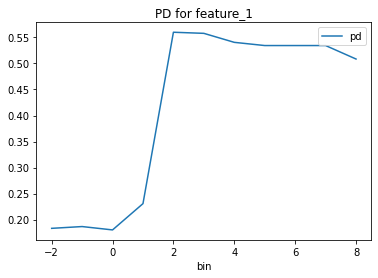

In [50]:
feature = "feature_1"
clazz = "class_A"

downloaded_path = h2oai.download(
    server_path.replace(
        "explanation.json", 
        pd_idx_json["features"][feature]["files"][clazz],  # feature file name
    ), 
    download_dir
)

with open(downloaded_path) as json_file:
    pd_json = json.load(json_file)

# show PD data for particular feature
pandas.DataFrame(
    pd_json["data"]
).plot(
    kind='line', title=f"PD for {feature}", legend=True,
    x="bin",
    y="pd",
)
plt.show()

## Get Local Explanations

Explainer run **job** descriptor also provides information about **types** and **formats** of available **local** explanations. Explainations for individual dataset rows (instances, examples) might be downloaded with job and descriptor data.

Let's download and **visualize** local partial dependence data i.e. **ICE** for feature `feature_1` and class `class_A`.

In [51]:
row = 1
feature = "feature_1"
clazz = "class_A"  # note labels map at the end of index file

local_explanation = h2oai.get_explainer_local_result(
    mli_key=mli_key,
    explainer_job_key=explainer_job_key,
    explanation_type="local-individual-conditional-explanation",
    explanation_format="application/vnd.h2oai.json+datatable.jay",
    id_column_value=row,
    id_column_name="",
    page_offset=0,
    page_size=1,
    result_format="application/json",
    explanation_filter=[
        messages.FilterEntry("explain_feature", feature),
        messages.FilterEntry("explain_class", clazz),
    ],
)

print(f"Local explanation:\n\n{local_explanation}")

Local explanation:

{"prediction": 0.8946140365149179, "feature_value": null, "data": [{"bin": "-2", "ice": 0.6607221248061429}, {"bin": "-1", "ice": 0.8500350678984244}, {"bin": "0", "ice": 0.8590345872890129}, {"bin": "1", "ice": 0.9019237796387912}, {"bin": "2", "ice": 0.014497705930532456}, {"bin": "3", "ice": 0.1615777588777586}, {"bin": "4", "ice": 0.9211793168428482}, {"bin": "5", "ice": 0.9697409041574396}, {"bin": "6", "ice": 0.5536619593147493}, {"bin": "7", "ice": 0.19689020656684897}, {"bin": "8", "ice": 0.7591244328671031}]}


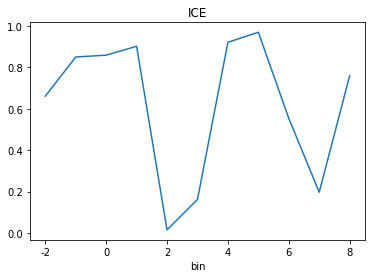

In [52]:
import pandas
import matplotlib.pyplot as plt

pandas.DataFrame(
    json.loads(local_explanation)["data"]
).plot(
    kind='line', title="ICE", legend=False,
    x="bin", y="ice",
)
plt.show()

**All** explainer's working data and explanations might be downloaded as ZIP archive:

In [53]:
server_path = h2oai.get_explainer_snapshot_url_path(
    mli_key=mli_key,
    explainer_job_key=explainer_job_key,
)
snapshot_url = f"{BASE_URL}{server_path}"
print(snapshot_url)
downloaded_artifact = h2oai.download(server_path, download_dir)
print(f"  {downloaded_artifact}")

http://127.0.0.1:12345/files/h2oai/mli_experiment_c9ab3796-59ed-11ec-8d3c-e86a64888647/explainer_False_template_pd_explainer_5e4f5ff0_contentexplainer_TemplatePartialDependenceExplainer_c9c5c3f4-59ed-11ec-8d3c-e86a64888647.zip
  /tmp/explainer_False_template_pd_explainer_5e4f5ff0_contentexplainer_TemplatePartialDependenceExplainer_c9c5c3f4-59ed-11ec-8d3c-e86a64888647.zip


Explainer **log** can be downloaded from:

In [54]:
server_path = h2oai.get_explainer_run_log_url_path(
    mli_key=mli_key,
    explainer_job_key=explainer_job_key,
)
print(f"{BASE_URL}{server_path}")

http://127.0.0.1:12345/files/h2oai/mli_experiment_c9ab3796-59ed-11ec-8d3c-e86a64888647/explainer_False_template_pd_explainer_5e4f5ff0_contentexplainer_TemplatePartialDependenceExplainer_c9c5c3f4-59ed-11ec-8d3c-e86a64888647/log/explainer_run_c9c5c3f4-59ed-11ec-8d3c-e86a64888647.log


URL from above can be used to **download** choosen **custom** recipe result representation.